In [75]:
from dataset import getMNIST
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from lenet5.nn import ConvNeuralNet
from utils import getTorchDevice
import torch

In [76]:
train_dataset, test_dataset, train_loader, test_loader = getMNIST(batch_size=64)

In [77]:
images = []
for i in range(64):
    images.append(train_dataset[i][0].reshape(32, 32))

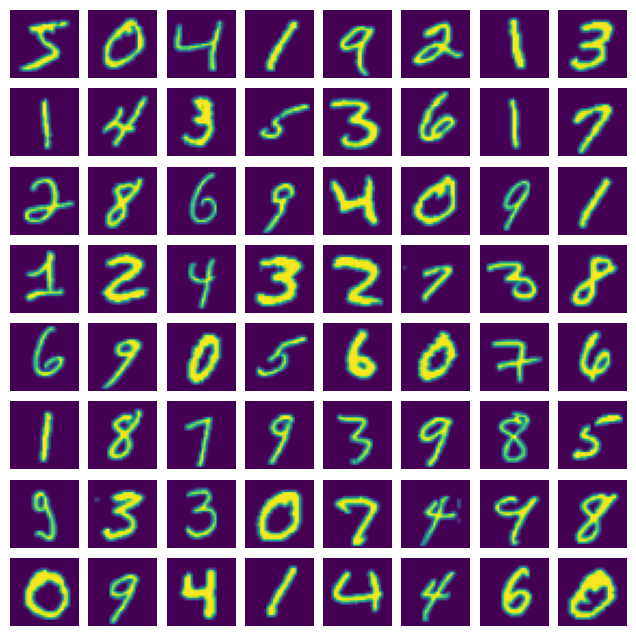

In [78]:
SHOULD_SHOW_SAMPLE_IMAGES = False
if (SHOULD_SHOW_SAMPLE_IMAGES):
    fig = plt.figure(figsize=(8., 8.))
    grid = ImageGrid(fig, 111, 
                    nrows_ncols=(8, 8), 
                    axes_pad=0.1, 
                    )

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis('off')
    plt.show()


In [79]:
device = getTorchDevice()
model = ConvNeuralNet(num_classes=10).to(device)

device, model

(device(type='mps'),
 ConvNeuralNet(
   (layer1): Sequential(
     (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
     (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (layer2): Sequential(
     (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
     (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc): Linear(in_features=400, out_features=120, bias=True)
   (relu): ReLU()
   (fc1): Linear(in_features=120, out_features=84, bias=True)
   (relu1): ReLU()
   (fc2): Linear(in_features=84, out_features=10, bias=True)
 ))

In [80]:
model.forward(torch.randn(64, 1, 32, 32).to(device))

tensor([[ 8.3364e-04, -5.4354e-02, -2.1683e-01,  7.1132e-02, -6.3815e-02,
          2.7194e-01, -1.3062e-01,  1.5693e-01, -8.6378e-02,  7.2497e-02],
        [ 5.3151e-02,  7.1523e-02, -9.8451e-02,  7.6707e-02,  7.4339e-02,
          2.7817e-01, -6.9192e-02,  2.0648e-01, -1.6960e-01, -4.7001e-02],
        [-3.4035e-02, -1.2092e-02, -7.7530e-02,  1.0971e-01,  7.1729e-03,
          2.7003e-01, -2.1111e-02,  2.0382e-01, -8.2389e-02, -5.2386e-03],
        [ 1.1140e-01, -5.6840e-02, -3.8780e-02, -1.1239e-02,  8.9071e-03,
          2.6798e-01, -9.5530e-02,  1.4505e-01, -8.7377e-02,  3.7777e-02],
        [-2.0758e-03, -2.1627e-03, -8.8404e-02,  2.1088e-02, -1.3674e-02,
          2.9694e-01, -1.1966e-01,  2.1350e-01, -1.0076e-01,  3.1558e-03],
        [ 5.3837e-02,  6.7056e-02, -1.4387e-01,  5.5652e-02,  1.0225e-01,
          2.8246e-01, -3.2317e-02,  2.5795e-01, -4.0929e-02, -1.4470e-02],
        [-3.0610e-02,  5.7741e-02, -1.2777e-01, -2.1102e-02, -2.5491e-02,
          3.0714e-01, -4.1690e-0